In [8]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 

from utilities import *
from VoxelGrid import VoxelGrid
import os

from pyvox.models import Vox, Color
from pyvox.writer import VoxWriter
from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200

In [2]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 42.65it/s]


In [3]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
200


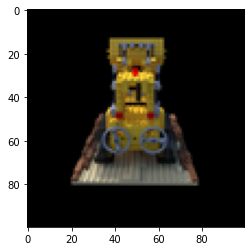

In [4]:
plt.imshow(target_ims[0])
plt.show()

In [5]:
test_focal, test_c2w, test_gt = get_data("../lego", "test")

LOAD DATA ../lego/test


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.07it/s]


In [6]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims[0].shape[0]

In [240]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


In [5]:
VG = VoxelGrid(4, 1.2)
VG.load('64_best.obj')
#VG.subdivide()

#plt.imshow(VG.render_image_from_rays(disp_rays[10],(500, 1.2)))

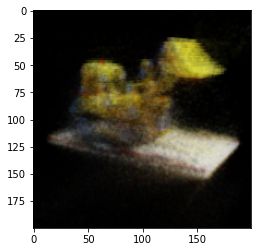

In [308]:
plt.imshow(VG.render_image_from_rays(disp_rays[10],(500, 1.2)))

In [293]:
losses=[]

In [294]:
2.4/0.075

32.0

In [298]:
N_points=200
def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        pix_estims = VG.render_rays(rays, (N_points))
        
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        loss.backward()
        losses.append(loss.item())
        VG.update_grads(1000)
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(2)):
    #new_im = VG.render_image_from_rays(disp_rays[0],(1000,1.2))
    #VG.treshold_opacity(0.2)
    #plt.show()
    #plt.imsave('screenshots/a'+str(epoch)+'.png', new_im)



    losses += train(epoch)
    #VG.save('80_'+str(epoch)+'.obj')
    
    

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Train Epoch: 0 [0/200 (0%)]	Loss: 0.253472
Train Epoch: 0 [10/200 (5%)]	Loss: 0.062978
Train Epoch: 0 [20/200 (10%)]	Loss: 0.050918


  0%|                                                     | 0/2 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
123/934

Text(0.5, 0, 'Iterations')

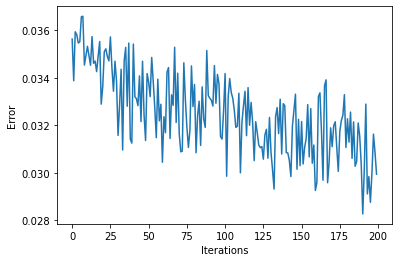

In [37]:
plt.plot((np.array(losses[400:])))




plt.ylabel("Error")
plt.xlabel("Iterations")
#plt.savefig('exports/2epochs_32.png')

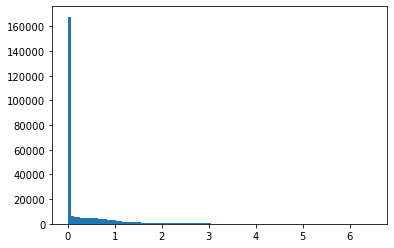

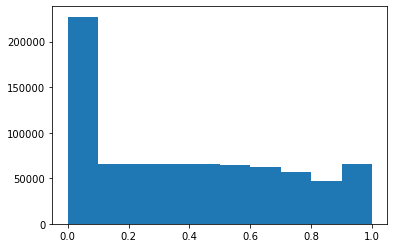

In [83]:
plt.hist(VG.opacities.tolist(), bins=100)
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




RuntimeError: The size of tensor a (300) must match the size of tensor b (40000) at non-singleton dimension 0

In [87]:
VG2 = VG.copy()


In [91]:
VG2.treshold_opacity(0.8)

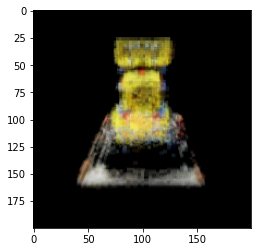

In [92]:
plt.imshow(VG2.render_image_from_rays(disp_rays[0],(1000, 1.2)))

In [93]:
VG.save_magica_vox(0.8)
#VG.save('.obj')

100%|███████████████████████████████████████████| 64/64 [00:26<00:00,  2.42it/s]


In [105]:
c = VG2.make_palette(16)

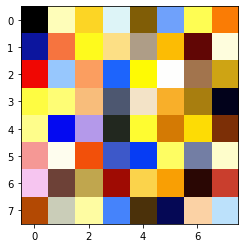

In [106]:
plt.imshow(c[1][:,:3].reshape((4,4,3)))

plt.imsave('exporsts/64_best_palette.png', c[1][:,:3].reshape((4,4,3)))

In [22]:
all_c2w[image_ind]

disp_rays[image_ind][0][0,:,0]**2

array([8.33201508, 6.31625955, 1.60172607])

# TEST

In [10]:
VG2 = VoxelGrid()
VG2.load('64_best.obj')
VG2.bound_w

1.2

In [22]:
len(disp_ims_test)

200

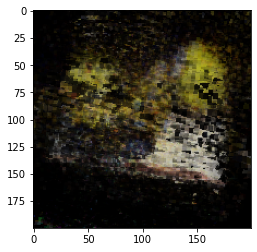

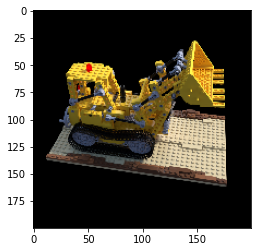

In [37]:
image_ind=28
tensor_rays_img = torch.tensor(disp_rays_test[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG2.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)
plt.show()
plt.imshow(disp_ims_test[image_ind])

# ROTATION

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


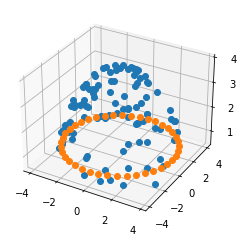

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [3]:
cust_c2ws = create_rotation_matrices(1,-10, n=40)

In [4]:
red_fac=4
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))



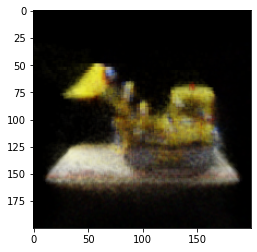

In [7]:
new_im = VG.render_image_from_rays(ordir_rays[0], (1000, 2))
plt.imshow(new_im)

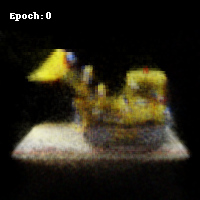

In [17]:
img

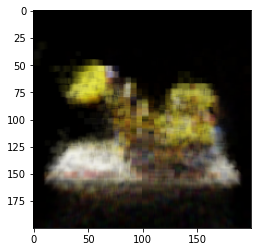

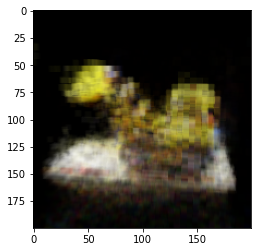

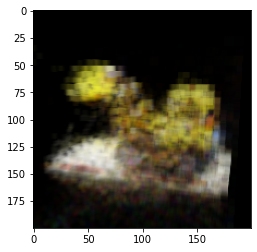

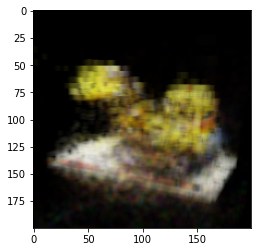

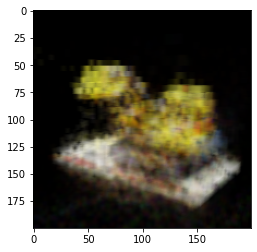

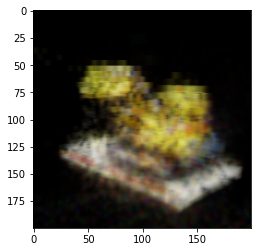

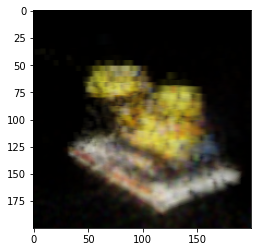

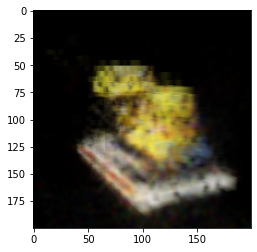

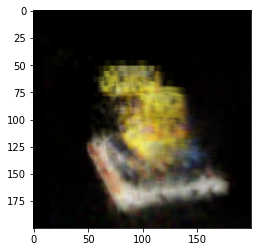

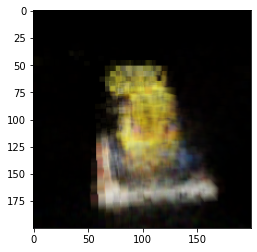

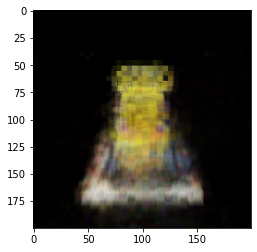

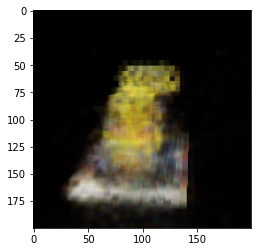

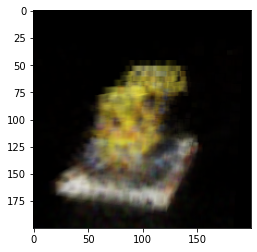

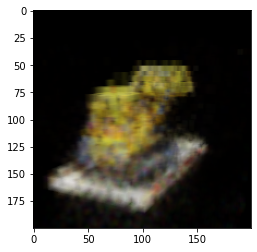

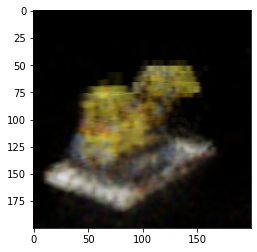

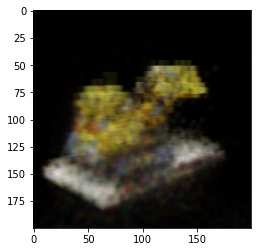

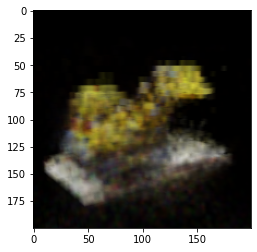

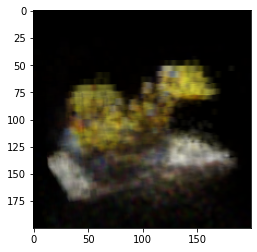

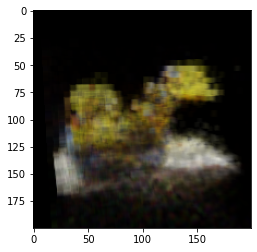

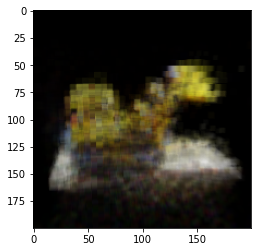

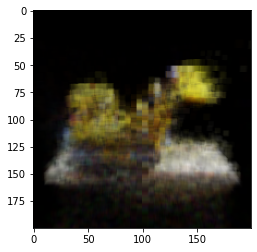

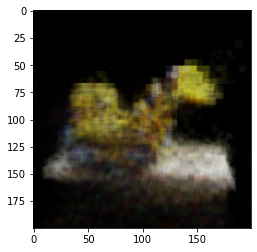

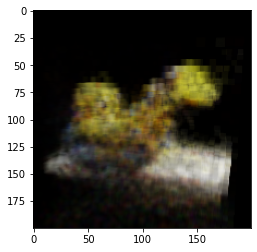

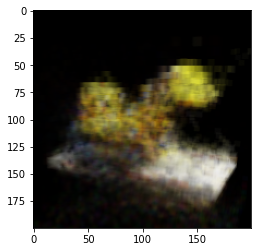

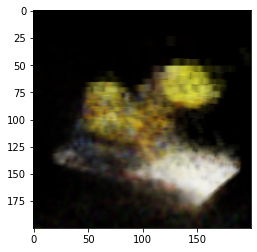

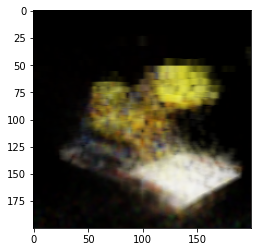

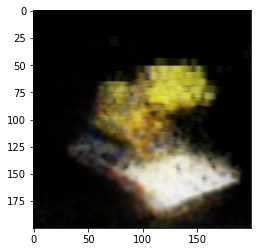

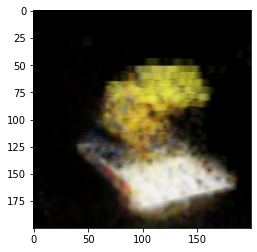

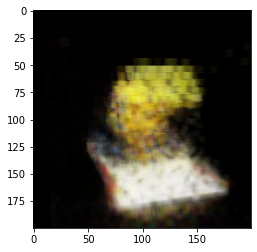

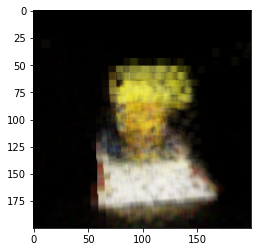

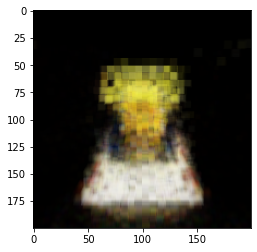

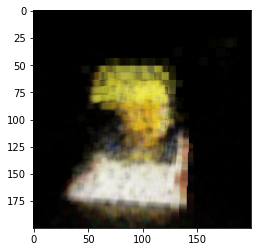

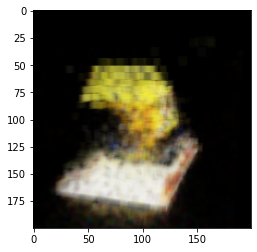

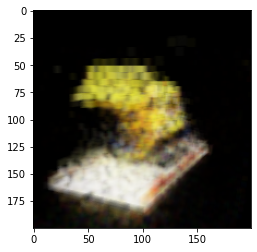

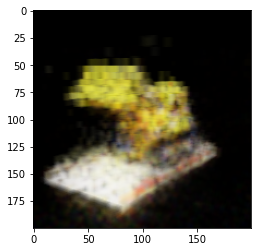

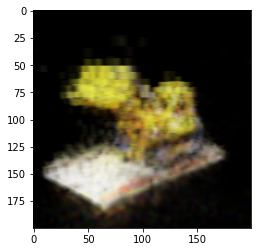

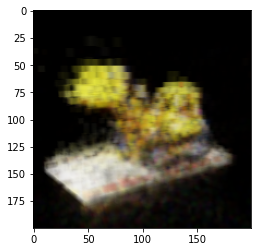

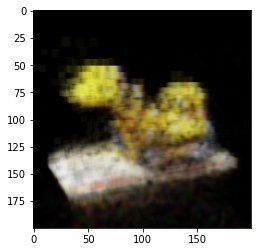

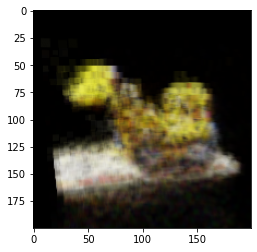

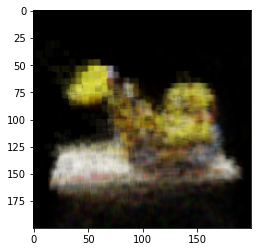

In [32]:
for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))
        plt.imshow(new_im)
        plt.show()

In [18]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

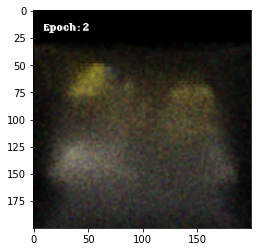

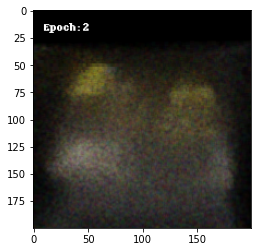

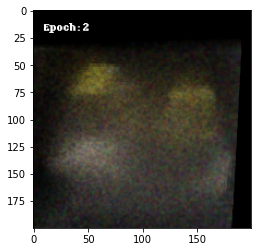

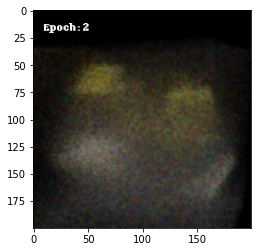

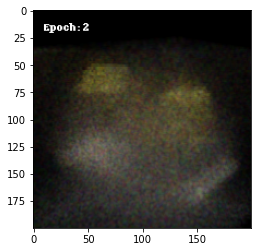

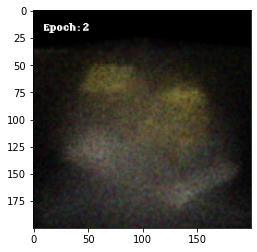

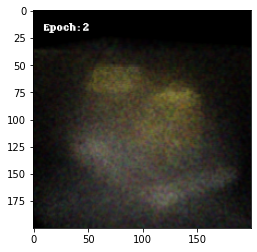

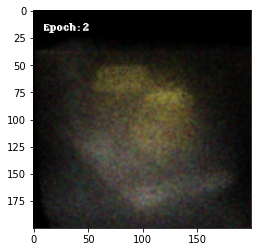

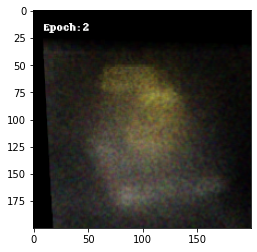

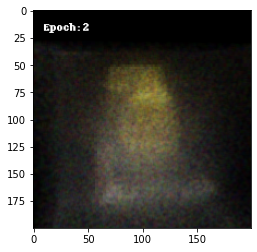

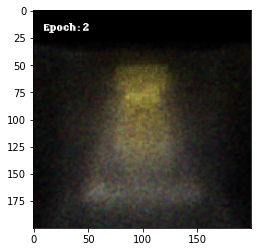

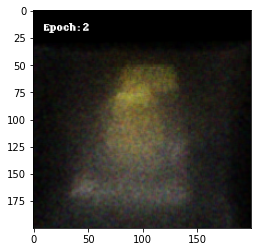

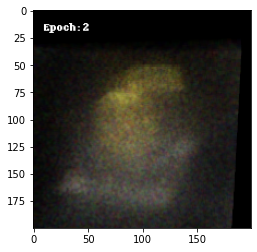

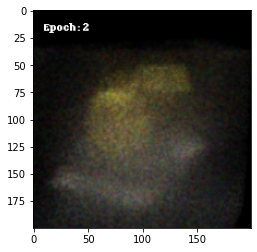

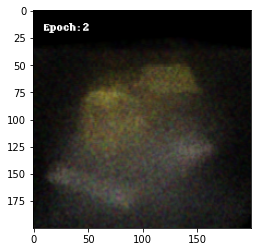

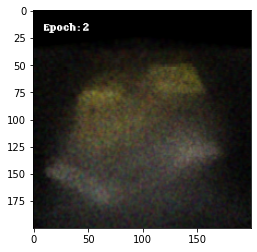

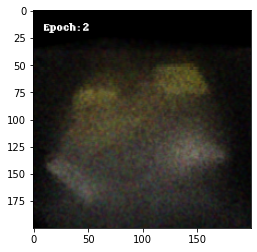

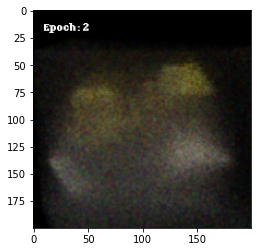

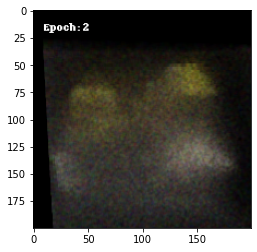

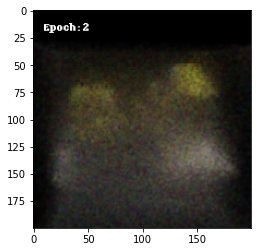

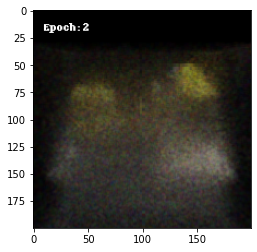

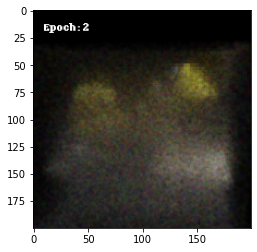

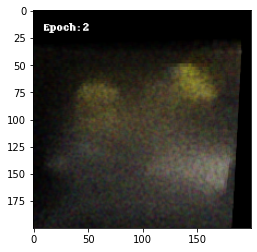

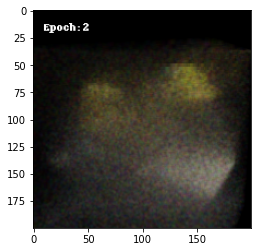

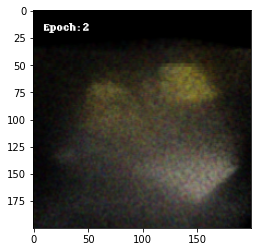

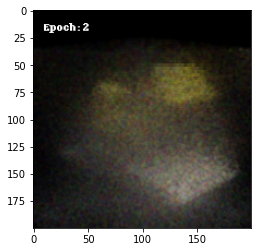

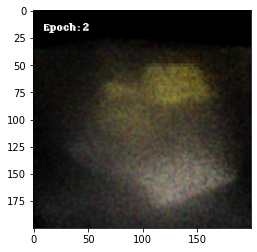

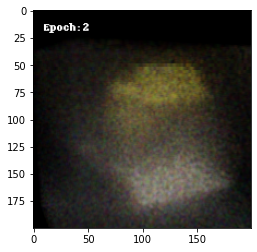

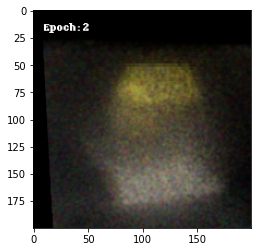

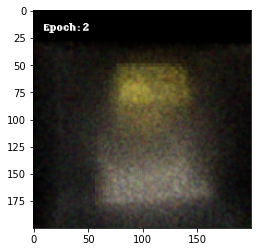

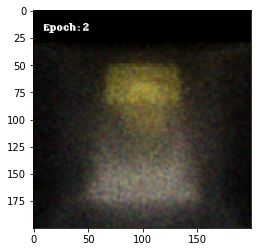

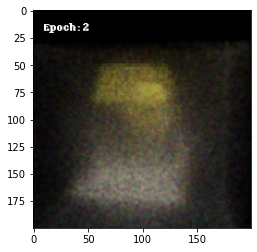

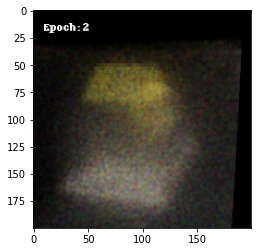

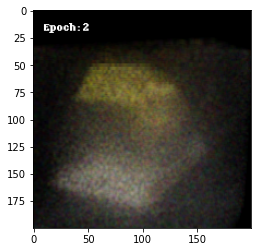

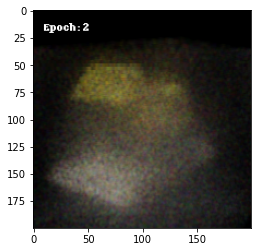

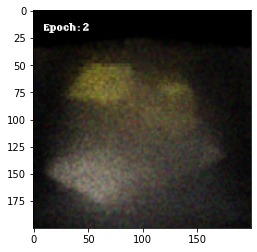

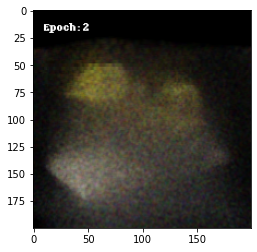

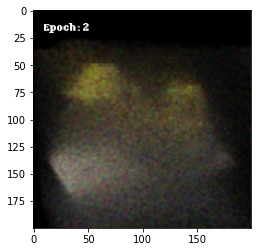

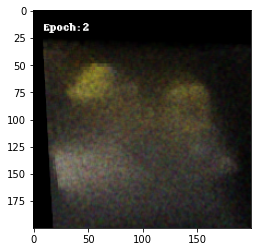

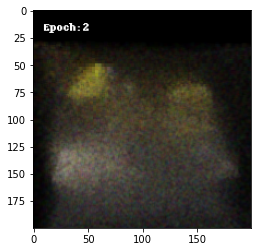

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


In [21]:

images=[]
for ind in tqdm(L):
    VG.load('64a_'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))
        img = Image.fromarray(np.uint8(255*new_im))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(255,255,255))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        images.append(np.uint8(255*new_im))
        plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


In [66]:
imageio.mimsave('screenshots/movies.gif', images,  format='GIF', duration=0.1)